# Setup

In [1]:
import itertools
import pickle
from pathlib import Path

import gc
import torch as t
from torch import nn, Tensor
from torch.nn import functional as F
import einops
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas
import plotly.express as px

from typing import Tuple, List, Optional, Dict
from jaxtyping import Float, Int
from functools import partial

import transformer_lens as tl
import datasets
from transformers import AutoTokenizer, GPT2LMHeadModel

from IPython.display import display, HTML, clear_output

device = t.device("cuda" if t.cuda.is_available() else "cpu")

DO_ATTN_SAE = False


# Load models and autoencoders
Joseph's SAEs on residual stream: https://huggingface.co/jbloom/GPT2-Small-SAEs
Github for Joseph's: https://github.com/jbloomAus/mats_sae_training
(post here: https://www.lesswrong.com/posts/f9EgfLSurAiqRJySD/open-source-sparse-autoencoders-for-all-residual-stream)

Colab for loading Kissane attention head autoencoders: https://colab.research.google.com/drive/1hZVEM6drJNsopLRd7hKajp_2v6mm_p70?usp=sharing (post here: https://www.lesswrong.com/posts/FSTRedtjuHa4Gfdbr/attention-saes-scale-to-gpt-2-small)


## Load Residual Stream Autoencoders

In [2]:
#Get joseph's autoencoders
if not Path('GPT2-Small-SAEs').exists():
    #requires git-lfs!
    !git clone https://huggingface.co/jbloom/GPT2-Small-SAEs
    !git clone https://github.com/jbloomAus/mats_sae_training.git
    !pip install -rq mats_sae_training/requirements.txt
    !mv mats_sae_training/* .

In [3]:
# Load residual stream autoencoders
from sae_training.utils import LMSparseAutoencoderSessionloader
from sae_training.sparse_autoencoder import SparseAutoencoder as ResidualSparseAutoencoder

sparse_encoders_residual = []

# load everything once
path = f"./GPT2-Small-SAEs/final_sparse_autoencoder_gpt2-small_blocks.{0}.hook_resid_pre_24576.pt"
model, sparse_autoencoder, activations_loader = LMSparseAutoencoderSessionloader.load_session_from_pretrained(
    path
)
sparse_autoencoder.cfg.use_ghost_grads = False
sparse_encoders_residual.append(sparse_autoencoder)

for i in tqdm(range(1, 12)):
    path = f"./GPT2-Small-SAEs/final_sparse_autoencoder_gpt2-small_blocks.{i}.hook_resid_pre_24576.pt"
    sparse_autoencoder = ResidualSparseAutoencoder.load_from_pretrained(path)
    sparse_autoencoder.cfg.use_ghost_grads = False
    sparse_encoders_residual.append(sparse_autoencoder)
clear_output()

In [4]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
hf_model = GPT2LMHeadModel.from_pretrained("gpt2")
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = hf_model(**inputs)

## Load Attention autoencoders

### Architecture

In [5]:
if DO_ATTN_SAE and not Path('attn-saes-gpt2-small-all-layers').exists():
    !git clone https://huggingface.co/ckkissane/attn-saes-gpt2-small-all-layers

In [6]:
DTYPES = {"fp32": t.float32, "fp16": t.float16, "bf16": t.bfloat16}
class AutoEncoder(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        d_hidden = cfg["dict_size"]
        l1_coeff = cfg["l1_coeff"]
        dtype = DTYPES[cfg["enc_dtype"]]
        t.manual_seed(cfg["seed"])
        self.W_enc = nn.Parameter(t.nn.init.kaiming_uniform_(t.empty(cfg["act_size"], d_hidden, dtype=dtype)))
        self.W_dec = nn.Parameter(t.nn.init.kaiming_uniform_(t.empty(d_hidden, cfg["act_size"], dtype=dtype)))
        self.b_enc = nn.Parameter(t.zeros(d_hidden, dtype=dtype))
        self.b_dec = nn.Parameter(t.zeros(cfg["act_size"], dtype=dtype))

        self.W_dec.data[:] = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)

        self.d_hidden = d_hidden
        self.l1_coeff = l1_coeff
        self.dtype = dtype
        self.device = cfg["device"]


        self.version = 0
        self.to(cfg["device"])

    def forward(self, x, per_token=False):
        x_cent = x - self.b_dec
        acts = F.relu(x_cent @ self.W_enc + self.b_enc) # [batch_size, d_hidden]
        x_reconstruct = acts @ self.W_dec + self.b_dec # [batch_size, act_size]
        if per_token:
            l2_loss = (x_reconstruct.float() - x.float()).pow(2).sum(-1) # [batch_size]
            l1_loss = self.l1_coeff * (acts.float().abs().sum(dim=-1)) # [batch_size]
            loss = l2_loss + l1_loss # [batch_size]
        else:
            l2_loss = (x_reconstruct.float() - x.float()).pow(2).sum(-1).mean(0) # []
            l1_loss = self.l1_coeff * (acts.float().abs().sum(dim=-1).mean(dim=0)) # []
            loss = l2_loss + l1_loss # []
        return loss, x_reconstruct, acts, l2_loss, l1_loss


    @classmethod
    def load_from_hf(cls, version, hf_repo="ckkissane/tinystories-1M-SAES"):
        """
        Loads the saved autoencoder from HuggingFace.
        """

        cfg = tl.utils.download_file_from_hf(hf_repo, f"{version}_cfg.json")
        self = cls(cfg=cfg)
        self.load_state_dict(tl.utils.download_file_from_hf(hf_repo, f"{version}.pt", force_is_torch=True))
        return self

In [7]:
if DO_ATTN_SAE:
    attn_sae_path = Path('attn-saes-gpt2-small-all-layers')
    files = sorted(attn_sae_path.glob('*.pt'), key= lambda x: int(str(x).split('_L')[-1].split('_Hcat')[0]))
    sparse_encoders_attn = []
    for f in tqdm(files):
        run = str(f).split('/')[-1].split('.pt')[0]
        #TODO load these from already downloaded files instead of HF.
        encoder = AutoEncoder.load_from_hf(run, hf_repo="ckkissane/attn-saes-gpt2-small-all-layers")
        sparse_encoders_attn.append(encoder)


# Testing functions

In [8]:
def test_next_token(prompts: list, answers: list, comparison_tokens: list = None,
                    sparse_encoder = None, act_name: str = None,
                    model_call=model.run_with_cache, tot=100, batch_size=10,
                    activations_length=128):
    """
    TODO: make this docstring not suck.
    Runs a bunch of prompts through a model where the goal is for the model to predict the next token
    and the answer is known.

    A sparse autoencoder can optionally be provided, in which case the autoencoder's performance is
    tracked on the questions being studied.

    Inputs:
    -------
    prompts: list
        A list object of strings which will be tokenized.
    answers: list
        a list of integers, containing the token value of the right answer.
    comparison_tokens: list, optional
        A list of integer lists (for each prompt, ther is a list of other tokens to compare model performance for.
    sparse_encoder: Autoencoder, optional
        An autoencoder object *** check that autoencoder returns things in the same order as your implementation.
    act_name: str, optional
        The name of the activation the autoencoder reconstructs.
    model_call: Callable, optional
        The function call to be used for a forward pass; should return a cache and logits.
    tot: int, optional
        Total number of prompts to do
    batch_size: int, optional
        Number of prompts to do in each batch
    activations_length: int, optional
        Number of autoencoder feature activations (from end of prompt backwards) to save and output

    Returns:
    --------
    info: dict, with the following items:
        top10_logit_vals:
        top10_logit_toks: 
        logit_norm: 
        top_diff:
        correct:
        logit_answer:
        logit_comparisons:
        sae_l0:
        sae_l1:
        activation_l2:
        sae_mse:
        num_tokens:
        feat_activations:
    """
    correct = 0

    info = {'top10_logit_vals': [], 'top10_logit_toks': [], 'logit_norm': [],
            'top_diff': [], 'correct': [], 'logit_answer': [], 'logit_comparisons': [],
            'sae_l0': [], 'sae_l1': [], 'activation_l2': [], 'sae_mse': [],
            'num_tokens': [], 'feat_activations' : []}
    #store top 10 logit predictions for each answer.
    # Also store logit_norm -> normalization factor to turn exp(logit) into a prob
    # Store correct (True/False)
    # Store logit answer (logit value of the correct answer token)
    # Also store top_diff, which:
    #   - if answer is correct, this is logit(correct) - logit(second highest)
    #   - if answer is incorrect, this is logit(highest) - logit(correct)
    for i in tqdm(range(tot // batch_size)):
        t.cuda.empty_cache()
        gc.collect()
        batch = model.to_tokens(prompts[batch_size*i:batch_size*(i+1)])
        last_indices = t.Tensor([model.to_tokens(prompts[batch_size*i + j]).shape[1]-1 for j in range(batch_size)]).to(int)
        output, cache = model_call(batch)


        last = output.argmax(dim=-1)
        preds = t.Tensor([last[i,j].item() for i, j in enumerate(last_indices)]).to(int)
        ans = t.Tensor([ans for ans in answers[batch_size*i:batch_size*(i+1)]]).to(int)
        correct_answer = preds == ans
        correct += (correct_answer).sum().item()
        # print(preds, ans, "'{:s}'".format(model.to_string(preds)), "'{:s}'".format(model.to_string(ans)))

        if comparison_tokens is not None:
            comparisons = comparison_tokens[batch_size*i:batch_size*(i+1)]

        for i, j in enumerate(last_indices):
            info['num_tokens'].append(j+1)

            top10 = t.topk(output[i,j], k=10, dim=-1)
            info['top10_logit_vals'].append(top10.values.detach().cpu().numpy())
            info['top10_logit_toks'].append(top10.indices.detach().cpu().numpy())
            info['logit_norm'].append(t.log(t.sum(t.exp(output[i,j]))).item())
            if correct_answer[i]:
                info['top_diff'].append((top10.values[0] - top10.values[1]).item())
            else:
                info['top_diff'].append((output[i,j,ans[i]] - top10.values[0]).item())
            info['correct'].append(correct_answer[i].item())
            info['logit_answer'].append(output[i,j,ans[i]].item())
            if comparison_tokens is not None:
                info['logit_comparisons'].append(t.gather(output[i,j], dim=-1, index=comparisons[i].to(device)).detach().cpu().numpy())

            #store SAE information
            #TODO: get act_name automatically.
            if sparse_encoder is not None:
                #note that the loss definitions are slightly different between residual and attn implementations; don't compare directly.
                if type(sparse_encoder) == AutoEncoder:
                    activation = cache[act_name][i,:j,:]
                    if sparse_encoder.cfg["concat_heads"]:
                        activation = einops.rearrange(
                                activation, "seq n_heads d_head -> seq (n_heads d_head)"
                        )
                    loss, sae_out, feature_acts, mse_loss, l1_loss = sparse_encoder(activation)
                    if not sparse_encoder.cfg["concat_heads"]:
                        feature_acts = einops.rearrange(
                                feature_acts, "seq n_heads d_head -> seq (n_heads d_head)"
                        )
                elif sparse_encoder is not None:
                    activation = cache[act_name][i,:j,:]
                    sae_out, feature_acts, loss, mse_loss, l1_loss, mse_loss_ghost_resid = sparse_encoder(activation)
                l0 = (feature_acts > 0).float().sum(dim=-1).mean()
                info['sae_l0'].append(l0.item())
                info['sae_l1'].append(l1_loss.item())
                info['sae_mse'].append(mse_loss.item())
                info['activation_l2'].append(t.norm(activation, dim=-1).mean().item())
                info['feat_activations'].append(feature_acts[-activations_length:].detach().cpu().numpy())
                # print(info['feat_activations'][-1].shape)

    print(f'acc: {100*correct/tot:.2f}%')
    for k in info.keys():
        info[k] = np.array(info[k])
    return info


# Test performance vs context length

We want to see how the model performs at different contexts lengths than the one it was trained on


In [24]:
from sae_training.activations_store import ActivationsStore
from sae_training.config import LanguageModelSAERunnerConfig
test_prompts = 100
context_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
measure_window = 128
batch_size = 2
tok_per_batch = 1024*batch_size

In [25]:
act_loader = activations_loader
# act_loader = activations_loader
act_store_cfg = act_loader.cfg.__dict__
for k in ['feature_sampling_method', 'resample_batches', 'feature_reinit_scale', 'dead_feature_estimation_method', 'd_sae', 'tokens_per_buffer', 'run_name']:
    try:
        del act_store_cfg[k]
    except:
        pass

act_stores = []
for context_size in context_sizes:
    act_store_cfg['context_size'] = context_size
    act_store_cfg['store_batch_size'] = tok_per_batch // context_size
    cfg = LanguageModelSAERunnerConfig(**act_store_cfg)
    print(cfg)
    
    gc.collect()
    t.cuda.empty_cache()
    act_store = ActivationsStore(cfg, model)
    act_stores.append(act_store)

Run name: 24576-L1-8e-05-LR-0.0004-Tokens-3.000e+08
n_tokens_per_buffer (millions): 0.262144
Lower bound: n_contexts_per_buffer (millions): 0.262144
Total training steps: 73242
Total wandb updates: 732
n_tokens_per_feature_sampling_window (millions): 4.096
n_tokens_per_dead_feature_window (millions): 20.48
Using Ghost Grads.
We will reset the sparsity calculation 73 times.
Number tokens in sparsity calculation window: 4.10e+06
LanguageModelSAERunnerConfig(model_name='gpt2-small', hook_point='blocks.0.hook_resid_pre', hook_point_layer=0, hook_point_head_index=None, dataset_path='Skylion007/openwebtext', is_dataset_tokenized=False, context_size=1, use_cached_activations=False, cached_activations_path='activations/Skylion007_openwebtext/gpt2-small/blocks.0.hook_resid_pre', d_in=768, n_batches_in_buffer=128, total_training_tokens=300000000, store_batch_size=2048, device=device(type='cuda'), seed=42, dtype=torch.float32, b_dec_init_method='geometric_median', expansion_factor=32, from_pretra

/home/eanders/miniconda3/envs/cuda_env/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Dataset is not tokenized! Updating config.
Run name: 24576-L1-8e-05-LR-0.0004-Tokens-3.000e+08
n_tokens_per_buffer (millions): 0.262144
Lower bound: n_contexts_per_buffer (millions): 0.131072
Total training steps: 73242
Total wandb updates: 732
n_tokens_per_feature_sampling_window (millions): 8.192
n_tokens_per_dead_feature_window (millions): 40.96
Using Ghost Grads.
We will reset the sparsity calculation 73 times.
Number tokens in sparsity calculation window: 4.10e+06
LanguageModelSAERunnerConfig(model_name='gpt2-small', hook_point='blocks.0.hook_resid_pre', hook_point_layer=0, hook_point_head_index=None, dataset_path='Skylion007/openwebtext', is_dataset_tokenized=False, context_size=2, use_cached_activations=False, cached_activations_path='activations/Skylion007_openwebtext/gpt2-small/blocks.0.hook_resid_pre', d_in=768, n_batches_in_buffer=128, total_training_tokens=300000000, store_batch_size=1024, device=device(type='cuda'), seed=42, dtype=torch.float32, b_dec_init_method='geometri

In [26]:

full_l0s = np.zeros((test_prompts, len(context_sizes), len(sparse_encoders_residual)))
for i in tqdm(range(int(np.ceil(test_prompts / act_store_cfg['store_batch_size'])))):
    l0s = [[] for i in range(len(sparse_encoders_residual))]
    with t.no_grad():
        
        gc.collect()
        t.cuda.empty_cache()
        # full_batch_tokens = act_store.get_batch_tokens() old version
        for j, context_size in enumerate(context_sizes):
            batch_tokens = act_stores[j].get_batch_tokens()
            ## batch_toks = []
            ## for b in range(tok_per_batch // (context_size*batch_size)):
            ##     batch_toks.append(act_store.get_batch_tokens()[:,:context_size])
            ## batch_tokens = t.concatenate(batch_toks, axis=0).to(device)
            # print(batch_tokens.shape)
            # batch_tokens = full_batch_tokens[:,-context_size:] old version
            _, cache = model.run_with_cache(batch_tokens, prepend_bos=True)
            for k, autoencoder in enumerate(sparse_encoders_residual):

                sae_out, feature_acts, loss, mse_loss, l1_loss, _ = autoencoder(
                    cache[autoencoder.cfg.hook_point][:,-measure_window:,:]
                )
                l0 = (feature_acts > 0).float().sum(-1).mean(-1).detach()
                for z in range(act_store_cfg['store_batch_size']):
                    idx = i*act_store_cfg['store_batch_size'] + z
                    full_l0s[idx,j,k] = l0[z]
                
            del cache
clear_output()

# full_l0s = np.array(full_l0s) #test_prompts x n_sae x context_size
print(full_l0s.shape)
print(full_l0s.mean(axis=0))


(100, 11, 12)
[[6.00000000e+00 5.00000000e+00 9.00000000e+00 1.20000000e+01
  1.10000000e+01 9.00000000e+00 1.20000000e+01 1.00000000e+01
  8.00000000e+00 1.20000000e+01 1.00000000e+01 9.00000000e+00]
 [1.02600000e+01 9.09500000e+00 1.18150000e+01 1.43750000e+01
  1.43500000e+01 1.42900000e+01 1.67500000e+01 1.66050000e+01
  1.64650000e+01 1.88650000e+01 1.46350000e+01 1.68350000e+01]
 [1.16825000e+01 1.17200000e+01 1.46775000e+01 2.04150000e+01
  2.29525000e+01 2.62025000e+01 2.90450000e+01 3.06525000e+01
  3.23175000e+01 3.51850000e+01 2.61575000e+01 3.03350000e+01]
 [1.44425000e+01 1.39362500e+01 1.76350000e+01 2.49812500e+01
  2.98187500e+01 3.58637500e+01 3.93712500e+01 4.38375000e+01
  4.66212500e+01 4.91750000e+01 3.66225000e+01 4.04775000e+01]
 [1.63962500e+01 1.52500000e+01 1.97831250e+01 2.71056250e+01
  3.26087500e+01 4.09018750e+01 4.59062500e+01 5.12400000e+01
  5.58150000e+01 5.94800000e+01 4.42118750e+01 4.81706250e+01]
 [1.57212500e+01 1.59606250e+01 2.01650000e+01 2.72

In [96]:
full_baseline_losses = np.zeros((test_prompts, len(context_sizes)))
full_sae_losses = np.zeros((test_prompts, len(context_sizes), len(sparse_encoders_residual)))
for i in tqdm(range(int(np.ceil(test_prompts / act_store_cfg['store_batch_size'])))):
    with t.no_grad():
        # full_batch_tokens = act_store.get_batch_tokens() old version
        for j, context_size in enumerate(context_sizes):
            batch_tokens = act_stores[j].get_batch_tokens()
            # batch_toks = []
            # for b in range(tok_per_batch // (context_size*batch_size)):
            #     batch_toks.append(act_store.get_batch_tokens()[:,-context_size:])
            # batch_tokens = t.concatenate(batch_toks, axis=0).to(device)
            # batch_tokens = full_batch_tokens[:,-context_size:] old version
            logits = model(batch_tokens, prepend_bos=True)
            orig_loss = tl.utils.lm_cross_entropy_loss(logits[:,-measure_window:,:], batch_tokens[:,-measure_window:], per_token=True)
            _, cache = model.run_with_cache(batch_tokens, prepend_bos=True)
            for k, autoencoder in enumerate(sparse_encoders_residual):
                gc.collect()
                t.cuda.empty_cache()

                def reconstr_hook(activation, hook):
                    sae_out, feature_acts, loss, mse_loss, l1_loss, _ = autoencoder(activation)
                    return sae_out

                def zero_abl_hook(activation, hook):
                    return t.zeros_like(activation)

                reconst_logits = model.run_with_hooks(
                    batch_tokens,
                    fwd_hooks=[
                        (autoencoder.cfg.hook_point, reconstr_hook)
                        ],
                    prepend_bos=True
                )
                reconst_loss = tl.utils.lm_cross_entropy_loss(reconst_logits[:,-measure_window:,:], batch_tokens[:,-measure_window:], per_token=True)
                
                for z in range(act_store_cfg['store_batch_size']):
                    idx = i*act_store_cfg['store_batch_size'] + z
                    if k == 0:
                        full_baseline_losses[idx,j] = orig_loss[z].mean().item()
                    full_sae_losses[idx,j,k] = reconst_loss[z].mean().item()
clear_output()

print(full_baseline_losses.mean(axis=0))
print(full_sae_losses.mean(axis=0))

[       nan 8.96681288 6.8953991  5.38098265 4.61388213 4.13465034
 3.78252724 3.5690729  3.20049658 3.12058057 2.94740916]
[[        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan]
 [ 8.97019145  8.96105985  8.96406733  9.01115266  8.99137976  8.93454032
   8.97863056  8.9560409   8.98868487  8.86496732  9.30698955  8.97551945]
 [ 6.92136336  6.91266365  6.9206279   6.92155686  6.91946491  6.90598241
   6.94031265  6.91147492  6.93193505  6.89949474  7.10034668  6.96813143]
 [ 5.41490357  5.41174076  5.43629587  5.45516938  5.4626668   5.44618299
   5.45437208  5.45476993  5.46975223  5.4835192   5.59293964  5.55146863]
 [ 4.63889909  4.63429139  4.66689724  4.71587741  4.69716257  4.70916246
   4.71405613  4.70952564  4.71928449  4.73473175  4.79542159  4.78753416]
 [ 4.16098191  4.15643703  4.22153343  4.29019141  4.26155581  4.26998826
   4.27817579  4.29134395  4.2990079   4.30006479  4.3691

In [97]:
xaxis = [[s for i in range(len(sparse_encoders_residual))]for s in context_sizes]
tolist = lambda x: list(itertools.chain.from_iterable(x))
df = pandas.DataFrame()
df['context_size'] = tolist(xaxis)
df['l0s'] = full_l0s.mean(axis=0).ravel()
df['loss_base'] = np.repeat(full_baseline_losses.mean(axis=0),len(sparse_encoders_residual)).reshape(len(context_sizes), len(sparse_encoders_residual)).ravel()
df['loss_reconst'] = full_sae_losses.mean(axis=0).ravel()
df['delta_CE_loss'] = np.array(df['loss_reconst']) - np.array(df['loss_base'])
df['layer'] = tolist([[j for j in range(len(sparse_encoders_residual))] for i in range(len(context_sizes))])

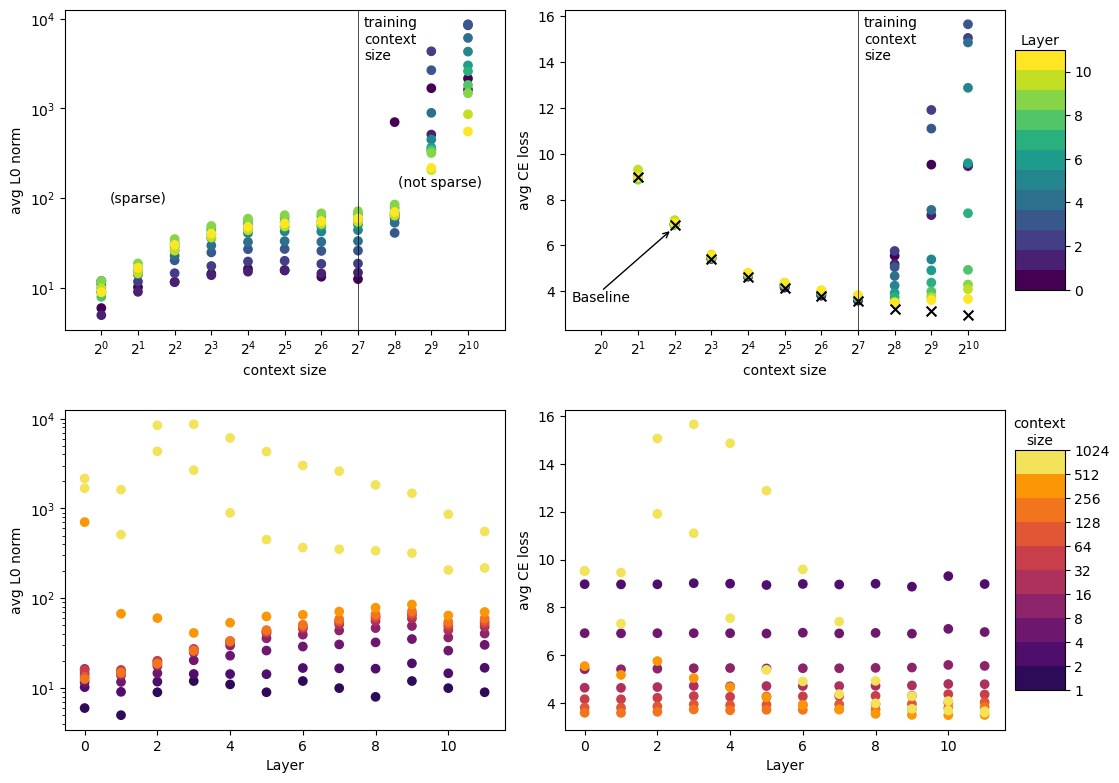

In [103]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_axes([0,    0.55, 0.44, 0.4])
ax2 = fig.add_axes([0.50, 0.55, 0.44, 0.4])
ax3 = fig.add_axes([0,    0.05, 0.44, 0.4])
ax4 = fig.add_axes([0.50, 0.05, 0.44, 0.4])
cax1 = fig.add_axes([0.95, 0.6, 0.05, 0.3])
cax2 = fig.add_axes([0.95, 0.1, 0.05, 0.3])

output = ax1.scatter(df['context_size'], df['l0s'], c=df['layer'], cmap=matplotlib.cm.viridis.resampled(12))
output = ax2.scatter(df['context_size'], df['loss_reconst'], c=df['layer'], cmap=matplotlib.cm.viridis.resampled(12))
ax2.scatter(df['context_size'][::len(context_sizes)], df['loss_base'][::len(context_sizes)], c='k', marker='x', s=50)
cb = plt.colorbar(output, cax=cax1)


norm = matplotlib.colors.Normalize(vmin=-2, vmax=11)
sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.inferno)

bounds = [i for i in range(0, 11)]
colors = matplotlib.colors.ListedColormap([sm.to_rgba(i) for i in bounds])
norm = matplotlib.colors.BoundaryNorm(bounds, colors.N)
sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=colors)

output = ax3.scatter(df['layer'], df['l0s'], c=sm.to_rgba(np.log2(df['context_size'])))#, cmap=matplotlib.cm.inferno.resampled(11))
ax4.scatter(df['layer'], df['loss_reconst'], c=sm.to_rgba(np.log2(df['context_size'])))
# ax3.scatter(df['context_size'][::len(context_sizes)], df['loss_base'][::len(context_sizes)], c='k', marker='x', s=50)
cb = plt.colorbar(sm, cax=cax2, norm=norm)

cb.set_ticks([np.log2(c) for c in context_sizes], labels=context_sizes)

ax1.text(2, 100, '(sparse)', ha='center', va='center')
ax1.text(600, 150, '(not sparse)', ha='center', va='center')

for ax in [ax1, ax3]:
    ax.set_ylabel('avg L0 norm')
for ax in [ax2, ax4]:
    ax.set_ylabel('avg CE loss')
    
for ax in [ax1, ax2,]:
    ax.set_xlabel('context size')
    ax.set_xscale('log')
    ax.axvline(128, c='k', lw=0.5)
    ax.text(0.68, 0.98, 'training\ncontext\nsize', ha='left', va='top', transform=ax.transAxes)
    ax.set_xticks(context_sizes, labels=[r'$2^{{{}}}$'.format(int(np.log2(c))) for c in context_sizes])
    ax.tick_params(which='minor', color='w')
    ax.set_xlim(0.5, 2048)

for ax in [ax3, ax4]:
    ax.set_xlabel('Layer')

ax1.set_yscale('log')
ax3.set_yscale('log')

ax2.text(1, 4, 'Baseline', ha='center', va='top')
ax2.annotate("", xy=(3.8, 6.7), xytext=(1, 4), arrowprops=dict(arrowstyle="->"))

cax1.text(0.5, 1.01, 'Layer', ha='center', va='bottom', transform=cax1.transAxes)
cax2.text(0.5, 1.01, 'context\nsize', ha='center', va='bottom', transform=cax2.transAxes)



fig.savefig('context_sizes.png', dpi=300, bbox_inches='tight')

In [102]:
#safe df to file for plotting offline if we want to do that sans-gpu
df.to_csv("context_size_df.csv")

# Children's Book Test

Original paper: https://arxiv.org/pdf/1511.02301.pdf


GPT2 paper context:

"Following the LM approach introduced in the original paper, we compute *the
probability of each choice and the rest of the sentence conditioned on this choice according to the LM, and predict
the one with the highest probability.* ... Data overlap analysis showed one of the CBT
test set books, The Jungle Book by Rudyard Kipling, is in
WebText, so we report results on the validation set which
has no significant overlap. ... A de-tokenizer was applied to remove PTB style
tokenization artifacts from CBT."

We'll just get logit distribution on the 'fill-in' token prediction, show probability ratio of the correct answer in that set vs median prob

In [96]:
cbt = datasets.load_dataset("cbt", 'CN', split='validation')

In [97]:
sentences = cbt['sentences']
question = cbt['question']
answer = cbt['answer']
options = cbt['options']

In [219]:
cbt_prompts = [''.join([s+' ' for s in text] + [question.split('XXXXX')[0][:-1]]) for text,question in zip(sentences,question)]
cbt_answers = [tokenizer.encode(' '+ text)[0] for text in answer]
cbt_choices = [t.Tensor([tokenizer.encode(' ' + option)[0] for option in opts]).to(int) for opts in options]
cbt_points = 1000
batch_size = 2

In [220]:
model.reset_hooks()
gc.collect()
t.cuda.empty_cache()
cbt_baseline = test_next_token(cbt_prompts, cbt_answers, comparison_tokens = cbt_choices,
                    model_call=model.run_with_cache, tot=cbt_points, batch_size=batch_size)

  0%|          | 0/500 [00:00<?, ?it/s]

acc: 41.90%


In [221]:
cbt_residual_logs = []
model.reset_hooks()
for i, sparse_autoencoder in enumerate(sparse_encoders_residual):
    def residual_replacement_hook(activations, hook):
        sae_out = sparse_autoencoder.forward(activations)[0].to(activations.dtype)
        activations[:] = sae_out

    act_name = sparse_autoencoder.cfg.hook_point

    model.add_hook(act_name, residual_replacement_hook)
    model_runner = model.run_with_cache

    print(f'running encoder on activation { act_name } ')
    this_log = test_next_token(cbt_prompts, cbt_answers, comparison_tokens = cbt_choices,
                                sparse_encoder = sparse_autoencoder, act_name=act_name,
                                model_call=model_runner, tot=cbt_points, batch_size=batch_size)
    this_log['feat_activations'] = (this_log['feat_activations'] > 0).sum(axis=1)
    cbt_residual_logs.append(this_log)

    model.reset_hooks()

running encoder on activation blocks.0.hook_resid_pre 


  0%|          | 0/500 [00:00<?, ?it/s]

acc: 0.10%
running encoder on activation blocks.1.hook_resid_pre 


  0%|          | 0/500 [00:00<?, ?it/s]

acc: 0.40%
running encoder on activation blocks.2.hook_resid_pre 


  0%|          | 0/500 [00:00<?, ?it/s]

acc: 0.00%
running encoder on activation blocks.3.hook_resid_pre 


  0%|          | 0/500 [00:00<?, ?it/s]

acc: 0.20%
running encoder on activation blocks.4.hook_resid_pre 


  0%|          | 0/500 [00:00<?, ?it/s]

acc: 0.20%
running encoder on activation blocks.5.hook_resid_pre 


  0%|          | 0/500 [00:00<?, ?it/s]

acc: 2.60%
running encoder on activation blocks.6.hook_resid_pre 


  0%|          | 0/500 [00:00<?, ?it/s]

acc: 4.80%
running encoder on activation blocks.7.hook_resid_pre 


  0%|          | 0/500 [00:00<?, ?it/s]

acc: 10.90%
running encoder on activation blocks.8.hook_resid_pre 


  0%|          | 0/500 [00:00<?, ?it/s]

acc: 18.40%
running encoder on activation blocks.9.hook_resid_pre 


  0%|          | 0/500 [00:00<?, ?it/s]

acc: 21.60%
running encoder on activation blocks.10.hook_resid_pre 


  0%|          | 0/500 [00:00<?, ?it/s]

acc: 24.30%
running encoder on activation blocks.11.hook_resid_pre 


  0%|          | 0/500 [00:00<?, ?it/s]

acc: 27.60%


In [222]:
if DO_ATTN_SAE:
    cbt_attn_logs = []
    model.reset_hooks()
    for i, sparse_autoencoder in enumerate(sparse_encoders_attn):
        act_name = sparse_autoencoder.cfg['act_name']
        def attn_replacement_hook(activations, hook):
            if sparse_autoencoder.cfg["concat_heads"]:
                acts = einops.rearrange(
                    activations, "batch seq n_heads d_head -> batch seq (n_heads d_head)",
                )
            sae_out = sparse_autoencoder.forward(acts)[1].to(activations.dtype)
            if sparse_autoencoder.cfg["concat_heads"]:
                activations[:] = einops.rearrange(
                        sae_out, "batch seq (n_heads d_head) -> batch seq n_heads d_head",
                        n_heads = activations.shape[2]
                    )
            else:
                activations[:] = sae_out

        model.add_hook(act_name, attn_replacement_hook)
        model_runner = model.run_with_cache

        print(f'running encoder on activation { act_name } ')
        this_log = test_next_token(cbt_prompts, cbt_answers, comparison_tokens = cbt_choices,
                                    sparse_encoder = sparse_autoencoder, act_name=act_name,
                                    model_call=model_runner, tot=cbt_points, batch_size=batch_size)
        cbt_attn_logs.append(this_log)

        model.reset_hooks()

In [244]:
#look at the mean and stdev delta probability of the correct answer for each SAE
baseline_ln_probs = cbt_baseline['logit_answer'] - cbt_baseline['logit_norm']

df = pandas.DataFrame()

name = []
delta_ln = []
l0 = []
l1 = []
mse = []
l2_activation = []
layers = []
df_answers = model.to_str_tokens([model.to_string(cbt_answers[i]) for i in range(cbt_points)], prepend_bos=False)*(24 if DO_ATTN_SAE else 12)
for i, log in enumerate(cbt_residual_logs):
    ln_probs = log['logit_answer'] - log['logit_norm']
    delta_ln_probs = (ln_probs - baseline_ln_probs)
    log['delta_ln_probs'] = delta_ln_probs
    delta_ln += list(delta_ln_probs)
    l0 += list(log['sae_l0'])
    l1 += list(log['sae_l1'])
    mse += list(log['sae_mse'])
    l2_activation += list(log['activation_l2'])
    name += [f'{sparse_encoders_residual[i].cfg.hook_point}'] * len(delta_ln_probs)
    layers += [int(sparse_encoders_residual[i].cfg.hook_point.split('.hook')[0].split('blocks.')[-1])]*len(delta_ln_probs)

if DO_ATTN_SAE:
    for i, log in enumerate(cbt_attn_logs):
        ln_probs = log['logit_answer'] - log['logit_norm']
        delta_ln_probs = (ln_probs - baseline_ln_probs)
        log['delta_ln_probs'] = delta_ln_probs
        delta_ln += list(delta_ln_probs)
        l0 += list(log['sae_l0'])
        l1 += list(log['sae_l1'])
        mse += list(log['sae_mse'])
        l2_activation += list(log['activation_l2'])
        act_name = sparse_encoders_attn[i].cfg['act_name']
        name += [f'{act_name}'] * len(delta_ln_probs)

df['delta_ln_prob'] = delta_ln
df['name'] = name
df['answers'] = df_answers
df['l0'] = l0
df['l1'] = l1
df['l2_activation'] = l2_activation
df['mse'] = mse
df['layer'] = layers




In [245]:
#feat_activations is [n_samples, n_features].
# feat_activations > 0 says when it's active.
# delta_ln_prob is [n_samples]
# for each feature (feat_activations[:,:,i] > 0) gives a mask for delta_ln_prob that lets me get a mean and stdev.
for i, log in enumerate(cbt_residual_logs):
    mask = log['feat_activations'] > 0
    feat_means = 100*np.ones(mask.shape[1])
    feat_stds = 100*np.ones_like(feat_means)
    for j in range(feat_means.shape[0]):
        if mask[:,j].sum() > 0:
            feat_means[j] = log['delta_ln_probs'][mask[:,j]].mean()
            feat_stds[j]  = log['delta_ln_probs'][mask[:,j]].std()
    log['feat_means'] = feat_means
    log['feat_stds'] = feat_stds

In [ ]:
#safe df to file for plotting offline if we want to do that sans-gpu
df.to_csv("cbt_df.csv")
for i, log in enumerate(cbt_residual_logs):
    with open(f'cbt_residual_log_{i}.pkl', 'wb') as handle:
        pickle.dump(log, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('cbt_baseline_log.pkl', 'wb') as handle:
    pickle.dump(cbt_baseline, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [226]:
df = pandas.read_csv('cbt_df.csv')

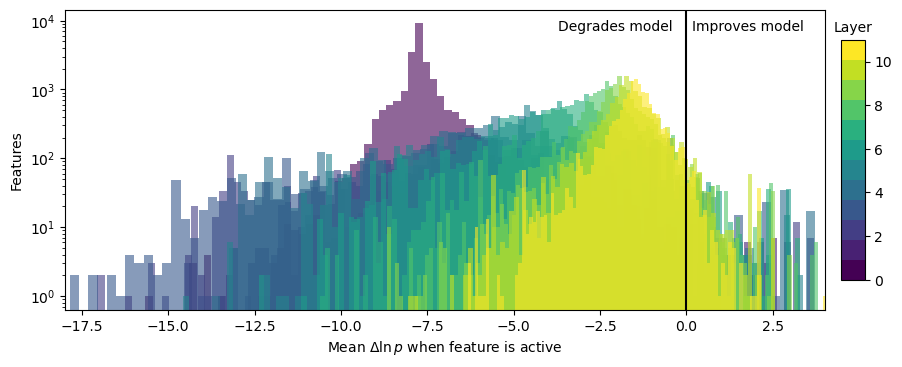

In [249]:
fig = plt.figure(figsize=(8,3))
ax1 = fig.add_axes((0, 0, 0.95, 1))
cax = fig.add_axes((0.97, 0.1, 0.03, 0.8))
for i,log in enumerate(cbt_residual_logs):
    ax1.hist(log['feat_means'][log['feat_means'] != 100], bins=100, color=matplotlib.cm.viridis.resampled(12)(i/12), alpha=0.6)
ax1.set_yscale('log')
ax1.set_xlabel(r'Mean $\Delta \ln p$ when feature is active')
ax1.set_ylabel('Features')
ax1.set_xlim(-18, 4)
ax1.axvline(0, c='k')
ax1.text(0.825, 0.93, 'Improves model', ha='left', transform=ax1.transAxes)
ax1.text(0.8, 0.93, 'Degrades model', ha='right', transform=ax1.transAxes)
cax.text(0.5, 1.05, 'Layer', ha='center', va='center', transform=cax.transAxes)
cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=11), cmap=matplotlib.cm.viridis.resampled(12)), cax=cax)

fig.savefig('feature_hist_cbt.png', dpi=300, bbox_inches='tight')

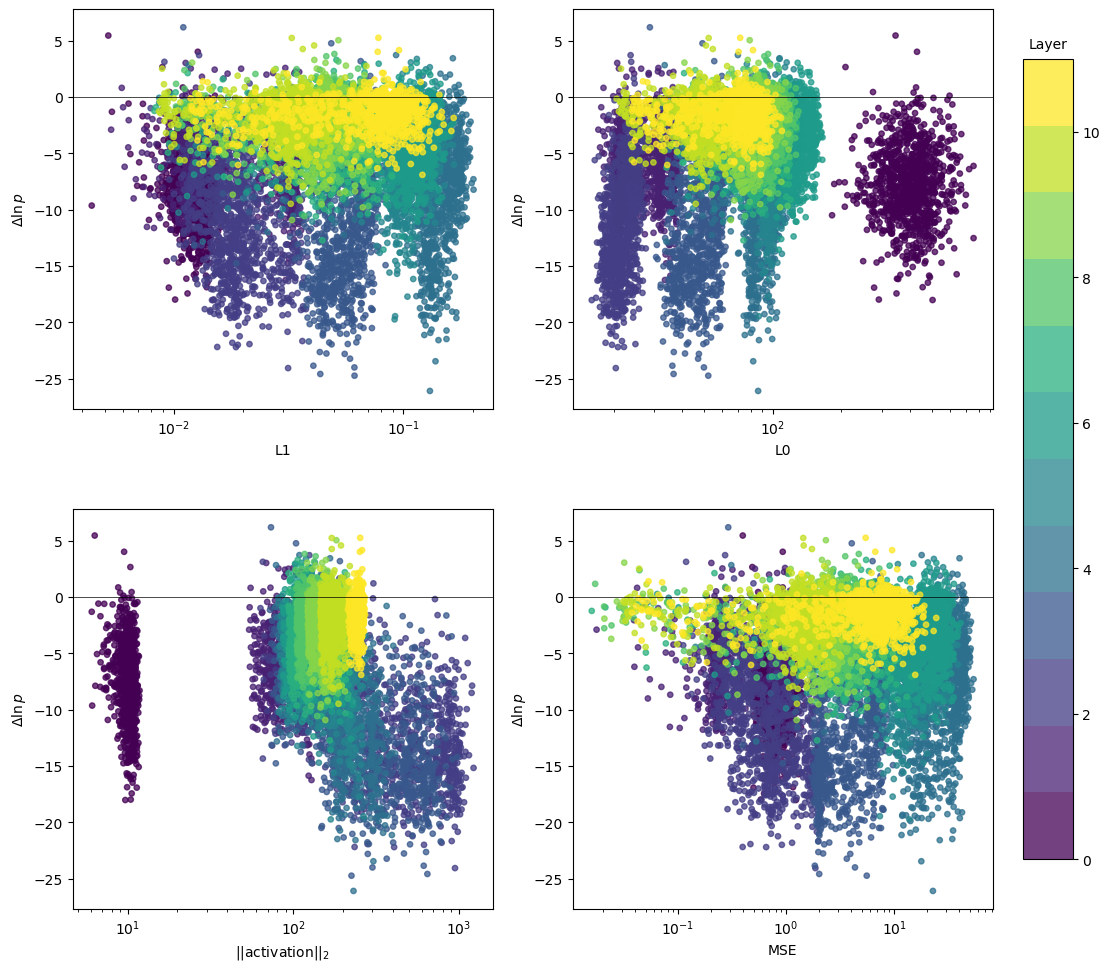

In [247]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_axes([0,    0.55, 0.42, 0.4])
ax2 = fig.add_axes([0.50, 0.55, 0.42, 0.4])
ax3 = fig.add_axes([0,    0.05, 0.42, 0.4])
ax4 = fig.add_axes([0.50, 0.05, 0.42, 0.4])
cax = fig.add_axes([0.95, 0.10, 0.05, 0.8])

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xscale('log')
    ax.set_ylabel(r'$\Delta \ln p$')
    ax.axhline(0, c='k', lw=0.5)

scatter_kwargs = dict(s=15, alpha=0.75, c=df['layer'], cmap=matplotlib.cm.viridis.resampled(12))
output = ax1.scatter(df['l1'], df['delta_ln_prob'], **scatter_kwargs)
output = ax2.scatter(df['l0'], df['delta_ln_prob'], **scatter_kwargs)
output = ax3.scatter(df['l2_activation'], df['delta_ln_prob'], **scatter_kwargs)
output = ax4.scatter(df['mse'], df['delta_ln_prob'], **scatter_kwargs)
# ax2.scatter(df['context_size'][:len(context_sizes)], df['loss_base'][:len(context_sizes)], c='k', marker='x', s=50)
cb = plt.colorbar(output, cax=cax)



# ax1.text(90, 20, '(sparse)', ha='center', va='center')
# ax1.text(800, 200, '(not sparse)', ha='center', va='center')

ax1.set_xlabel('L1')
ax2.set_xlabel('L0')
ax3.set_xlabel('||activation||$_2$')
ax4.set_xlabel('MSE')

    # ax.axvline(128, c='k', lw=0.5)
    # ax.text(0.28, 0.98, 'training\ncontext\nsize', ha='left', va='top', transform=ax.transAxes)

# ax1.set_yscale('log')

# ax2.text(100, 8, 'Baseline', ha='center', va='bottom')
# ax2.annotate("", xy=(65, 4.4), xytext=(100, 8), arrowprops=dict(arrowstyle="->"))

cax.text(0.5, 1.01, 'Layer', ha='center', va='bottom', transform=cax.transAxes)

fig.savefig('delta_ln_prob_cbt.png', dpi=300, bbox_inches='tight')

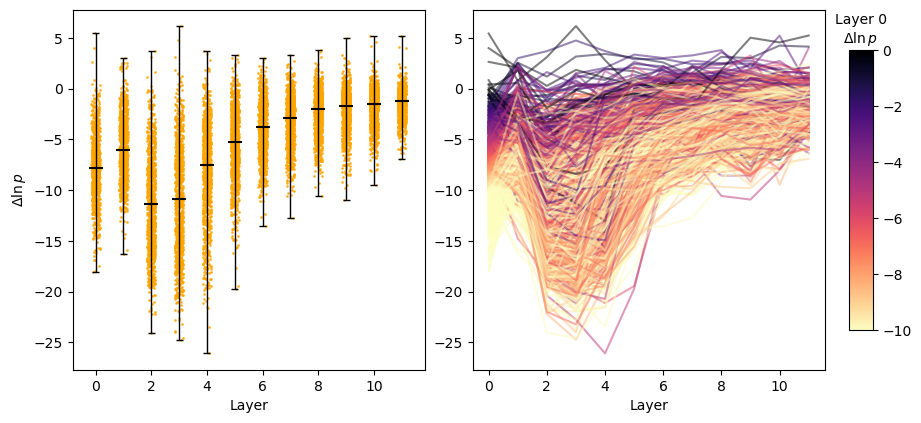

In [248]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_axes([0.00, 0.05, 0.44, 0.9])
ax2 = fig.add_axes([0.50, 0.05, 0.44, 0.9])
cax = fig.add_axes([0.97, 0.15, 0.03, 0.7])


parts = ax1.violinplot([df['delta_ln_prob'][df['layer'] == i] for i in range(12)], positions=np.arange(12))#, showmeans=True)
for partname in ('cbars','cmins','cmaxes'):#'cmeans','cmedians'):
    pc = parts[partname]
    # print(dir(pc))
    pc.set_color('k')
    pc.set_linewidth(1)
    pc.set_alpha(1)
for pc in parts['bodies']:
    pc.set_alpha(0)

    
ax1.scatter(df['layer'] + (np.random.rand(df['layer'].shape[0])-0.5)*0.3, df['delta_ln_prob'], s=1, alpha=0.75, c='orange')
ax1.set_xlabel('Layer')
ax1.set_ylabel(r'$\Delta \ln p$')


for i in range(12):
    ax1.scatter(i, np.percentile(df['delta_ln_prob'][df['layer'] == i], 50), marker='_', c='k', s=100)


# for each data point, get [layer, delta ln p]
x = [i for i in range(12)]
y = [np.array(df['delta_ln_prob'][i::cbt_points]) for i in range(cbt_points)]

norm = matplotlib.colors.Normalize(vmin=-10, vmax=0)
sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.magma_r)

for i in range(len(y)):
    ax2.plot(x, y[i], color=sm.to_rgba(y[i][0]), alpha=0.5);
plt.colorbar(sm, cax=cax)
ax2.set_xlabel('Layer')

cax.text(0.5, 1.07, 'Layer 0\n'+r'$\Delta \ln p$', ha='center', va='center', transform=cax.transAxes);

fig.savefig('layer_effect_cbt.png', dpi=300, bbox_inches='tight')

# Lambada

In [116]:
lambada = datasets.load_dataset("lambada")

Generating train split:   0%|          | 0/2662 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5153 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4869 [00:00<?, ? examples/s]

In [123]:
lambada_prompts = [text.rsplit(' ', 1)[0] for text in lambada['test']['text']]
lambada_answers = [tokenizer.encode(' ' + text.rsplit(' ', 1)[1])[0] for text in lambada['test']['text']]
lambada_points = 1000
lambada_batch_size = 20

In [124]:
max_len = len(lambada_prompts)
model.reset_hooks()
lambada_baseline = test_next_token(lambada_prompts, lambada_answers, model_call=model.run_with_cache, tot=lambada_points, batch_size=lambada_batch_size) #27.07% accuracy on 5150 prompts

  0%|          | 0/50 [00:00<?, ?it/s]

acc: 26.60%


In [125]:
t.cuda.empty_cache()
gc.collect()
lambada_residual_logs = []
model.reset_hooks()
for i, sparse_autoencoder in enumerate(sparse_encoders_residual):

    def residual_replacement_hook(activations, hook):
        sae_out = sparse_autoencoder.forward(activations)[0].to(activations.dtype)
        activations[:] = sae_out

    act_name = sparse_autoencoder.cfg.hook_point

    model.add_hook(act_name, residual_replacement_hook)
    model_runner = model.run_with_cache

    print(f'running encoder on activation { act_name } ')
    this_log = test_next_token(lambada_prompts, lambada_answers,
                                sparse_encoder = sparse_autoencoder, act_name=act_name,
                                model_call=model_runner, tot=lambada_points, batch_size=lambada_batch_size,
                                activations_length=32)
    this_log['feat_activations'] = (this_log['feat_activations'] > 0).sum(axis=1)
    lambada_residual_logs.append(this_log)

    model.reset_hooks()

running encoder on activation blocks.0.hook_resid_pre 


  0%|          | 0/50 [00:00<?, ?it/s]

acc: 25.60%
running encoder on activation blocks.1.hook_resid_pre 


  0%|          | 0/50 [00:00<?, ?it/s]

acc: 24.80%
running encoder on activation blocks.2.hook_resid_pre 


  0%|          | 0/50 [00:00<?, ?it/s]

acc: 22.40%
running encoder on activation blocks.3.hook_resid_pre 


  0%|          | 0/50 [00:00<?, ?it/s]

acc: 21.10%
running encoder on activation blocks.4.hook_resid_pre 


  0%|          | 0/50 [00:00<?, ?it/s]

acc: 20.30%
running encoder on activation blocks.5.hook_resid_pre 


  0%|          | 0/50 [00:00<?, ?it/s]

acc: 17.20%
running encoder on activation blocks.6.hook_resid_pre 


  0%|          | 0/50 [00:00<?, ?it/s]

acc: 17.80%
running encoder on activation blocks.7.hook_resid_pre 


  0%|          | 0/50 [00:00<?, ?it/s]

acc: 18.20%
running encoder on activation blocks.8.hook_resid_pre 


  0%|          | 0/50 [00:00<?, ?it/s]

acc: 16.90%
running encoder on activation blocks.9.hook_resid_pre 


  0%|          | 0/50 [00:00<?, ?it/s]

acc: 14.80%
running encoder on activation blocks.10.hook_resid_pre 


  0%|          | 0/50 [00:00<?, ?it/s]

acc: 13.20%
running encoder on activation blocks.11.hook_resid_pre 


  0%|          | 0/50 [00:00<?, ?it/s]

acc: 10.60%


In [126]:
if DO_ATTN_SAE:
    lambada_attn_logs = []
    model.reset_hooks()
    for i, sparse_autoencoder in enumerate(sparse_encoders_attn):
    
        def attn_replacement_hook(activations, hook):
            if sparse_autoencoder.cfg["concat_heads"]:
                acts = einops.rearrange(
                    activations, "batch seq n_heads d_head -> batch seq (n_heads d_head)",
                )
            sae_out = sparse_autoencoder.forward(acts)[1].to(activations.dtype)
            if sparse_autoencoder.cfg["concat_heads"]:
                activations[:] = einops.rearrange(
                        sae_out, "batch seq (n_heads d_head) -> batch seq n_heads d_head",
                        n_heads = activations.shape[2]
                    )
            else:
                activations[:] = sae_out
    
        act_name = sparse_autoencoder.cfg['act_name']
    
        model.add_hook(act_name, attn_replacement_hook)
        model_runner = model.run_with_cache
    
        print(f'running encoder on activation { act_name } ')
        this_log = test_next_token(lambada_prompts, lambada_answers,
                                    sparse_encoder = sparse_autoencoder, act_name=act_name,
                                    model_call=model_runner, tot=lambada_points, batch_size=lambada_batch_size,
                                  activations_length=32)
        this_log['feat_activations'] = (this_log['feat_activations'] > 0).sum(axis=1)
        lambada_attn_logs.append(this_log)
    
        model.reset_hooks()

In [250]:
#look at the mean and stdev delta probability of the correct answer for each SAE
baseline_ln_probs = lambada_baseline['logit_answer'] - lambada_baseline['logit_norm']

df = pandas.DataFrame()

name = []
delta_ln = []
l0 = []
l1 = []
mse = []
l2_activation = []
layers = []
df_answers = model.to_str_tokens([model.to_string(lambada_answers[i]) for i in range(lambada_points)], prepend_bos=False)*(24 if DO_ATTN_SAE else 12)
for i, log in enumerate(lambada_residual_logs):
    ln_probs = log['logit_answer'] - log['logit_norm']
    delta_ln_probs = (ln_probs - baseline_ln_probs)
    log['delta_ln_probs'] = delta_ln_probs
    delta_ln += list(delta_ln_probs)
    l0 += list(log['sae_l0'])
    l1 += list(log['sae_l1'])
    mse += list(log['sae_mse'])
    l2_activation += list(log['activation_l2'])
    name += [f'{sparse_encoders_residual[i].cfg.hook_point}'] * len(delta_ln_probs)
    layers += [int(sparse_encoders_residual[i].cfg.hook_point.split('.hook')[0].split('blocks.')[-1])]*len(delta_ln_probs)

if DO_ATTN_SAE:
    for i, log in enumerate(lambada_attn_logs):
        ln_probs = log['logit_answer'] - log['logit_norm']
        delta_ln_probs = (ln_probs - baseline_ln_probs)
        log['delta_ln_probs'] = delta_ln_probs
        delta_ln += list(delta_ln_probs)
        l0 += list(log['sae_l0'])
        l1 += list(log['sae_l1'])
        mse += list(log['sae_mse'])
        l2_activation += list(log['activation_l2'])
        act_name = sparse_encoders_attn[i].cfg['act_name']
        name += [f'{act_name}'] * len(delta_ln_probs)

df['delta_ln_prob'] = delta_ln
df['name'] = name
df['answers'] = df_answers
df['l0'] = l0
df['l1'] = l1
df['l2_activation'] = l2_activation
df['mse'] = mse
df['layer'] = layers




In [251]:
#feat_activations is [n_samples, n_features].
# feat_activations > 0 says when it's active.
# delta_ln_prob is [n_samples]
# for each feature (feat_activations[:,:,i] > 0) gives a mask for delta_ln_prob that lets me get a mean and stdev.
for i, log in enumerate(lambada_residual_logs):
    mask = log['feat_activations'] > 0
    feat_means = 100*np.ones(mask.shape[1])
    feat_stds = 100*np.ones_like(feat_means)
    for j in range(feat_means.shape[0]):
        if mask[:,j].sum() > 0:
            feat_means[j] = log['delta_ln_probs'][mask[:,j]].mean()
            feat_stds[j]  = log['delta_ln_probs'][mask[:,j]].std()
    log['feat_means'] = feat_means
    log['feat_stds'] = feat_stds

In [129]:
#safe df to file for plotting offline if we want to do that sans-gpu
df.to_csv("lambada_df.csv")
for i, log in enumerate(lambada_residual_logs):
    with open(f'lambada_residual_log_{i}.pkl', 'wb') as handle:
        pickle.dump(log, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('lambada_baseline_log.pkl', 'wb') as handle:
    pickle.dump(lambada_baseline, handle, protocol=pickle.HIGHEST_PROTOCOL)

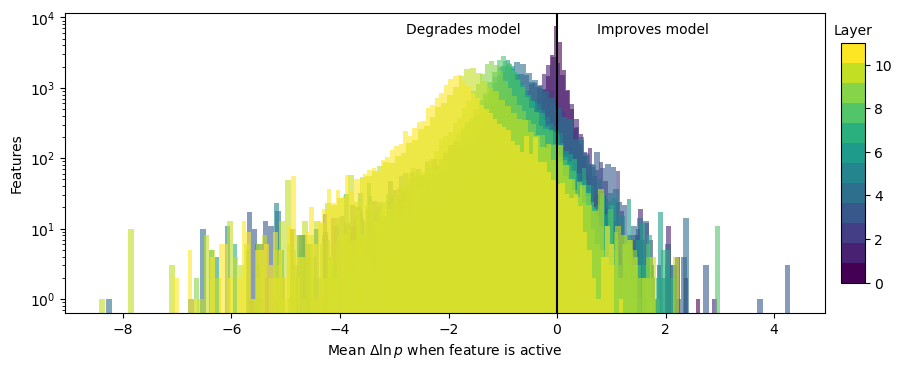

In [252]:
fig = plt.figure(figsize=(8,3))
ax1 = fig.add_axes((0, 0, 0.95, 1))
cax = fig.add_axes((0.97, 0.1, 0.03, 0.8))
for i,log in enumerate(lambada_residual_logs):
    ax1.hist(log['feat_means'][log['feat_means'] != 100], bins=100, color=matplotlib.cm.viridis.resampled(12)(i/12), alpha=0.6)
ax1.set_yscale('log')
ax1.set_xlabel(r'Mean $\Delta \ln p$ when feature is active')
ax1.set_ylabel('Features')
ax1.axvline(0, c='k')
ax1.text(0.7, 0.93, 'Improves model', ha='left', transform=ax1.transAxes)
ax1.text(0.6, 0.93, 'Degrades model', ha='right', transform=ax1.transAxes)
cax.text(0.5, 1.05, 'Layer', ha='center', va='center', transform=cax.transAxes)
cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=11), cmap=matplotlib.cm.viridis.resampled(12)), cax=cax)

fig.savefig('feature_hist_lambada.png', dpi=300, bbox_inches='tight')

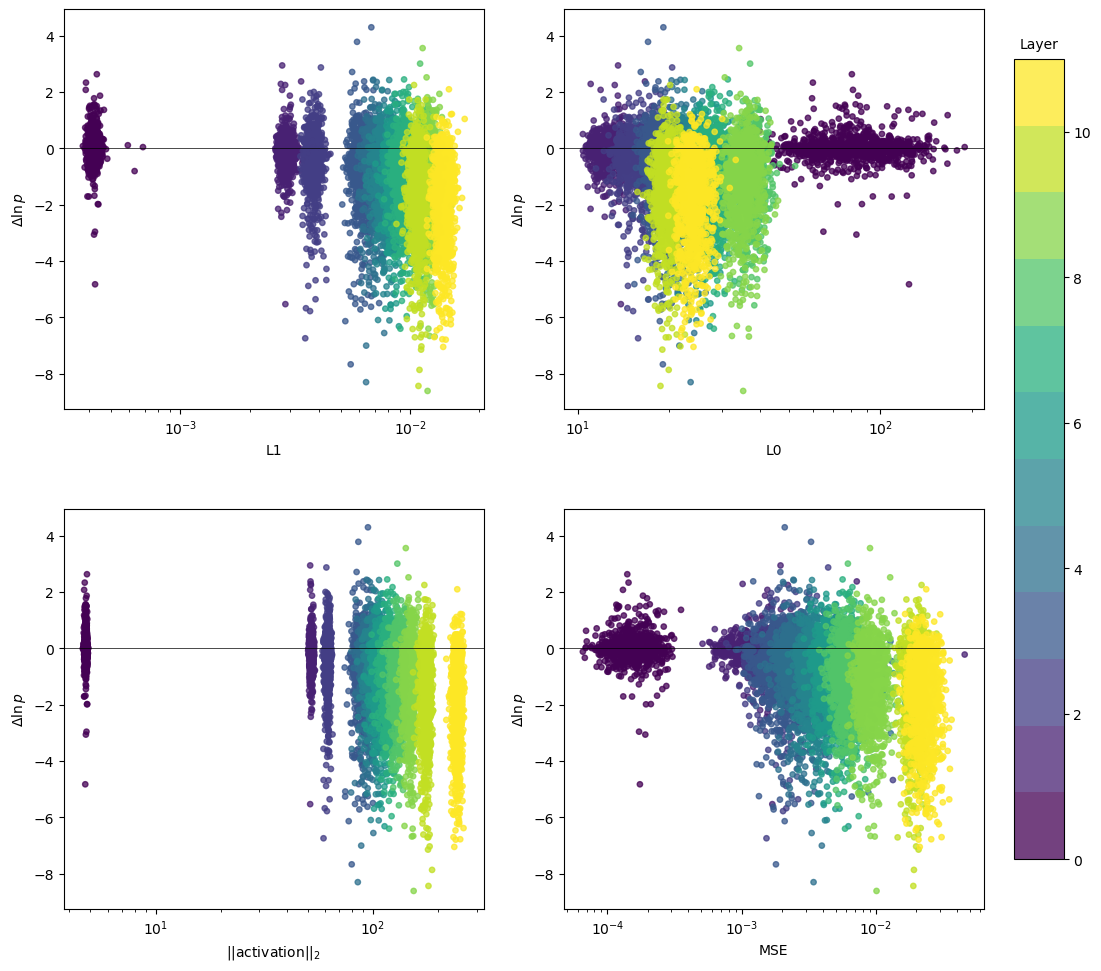

In [236]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_axes([0,    0.55, 0.42, 0.4])
ax2 = fig.add_axes([0.50, 0.55, 0.42, 0.4])
ax3 = fig.add_axes([0,    0.05, 0.42, 0.4])
ax4 = fig.add_axes([0.50, 0.05, 0.42, 0.4])
cax = fig.add_axes([0.95, 0.10, 0.05, 0.8])

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xscale('log')
    ax.set_ylabel(r'$\Delta \ln p$')
    ax.axhline(0, c='k', lw=0.5)

scatter_kwargs = dict(s=15, alpha=0.75, c=df['layer'], cmap=matplotlib.cm.viridis.resampled(12))
output = ax1.scatter(df['l1'], df['delta_ln_prob'], **scatter_kwargs)
output = ax2.scatter(df['l0'], df['delta_ln_prob'], **scatter_kwargs)
output = ax3.scatter(df['l2_activation'], df['delta_ln_prob'], **scatter_kwargs)
output = ax4.scatter(df['mse'], df['delta_ln_prob'], **scatter_kwargs)
# ax2.scatter(df['context_size'][:len(context_sizes)], df['loss_base'][:len(context_sizes)], c='k', marker='x', s=50)
cb = plt.colorbar(output, cax=cax)



# ax1.text(90, 20, '(sparse)', ha='center', va='center')
# ax1.text(800, 200, '(not sparse)', ha='center', va='center')

ax1.set_xlabel('L1')
ax2.set_xlabel('L0')
ax3.set_xlabel('||activation||$_2$')
ax4.set_xlabel('MSE')

    # ax.axvline(128, c='k', lw=0.5)
    # ax.text(0.28, 0.98, 'training\ncontext\nsize', ha='left', va='top', transform=ax.transAxes)

# ax1.set_yscale('log')

# ax2.text(100, 8, 'Baseline', ha='center', va='bottom')
# ax2.annotate("", xy=(65, 4.4), xytext=(100, 8), arrowprops=dict(arrowstyle="->"))

cax.text(0.5, 1.01, 'Layer', ha='center', va='bottom', transform=cax.transAxes)

fig.savefig('delta_ln_prob_lambada.png', dpi=300, bbox_inches='tight')

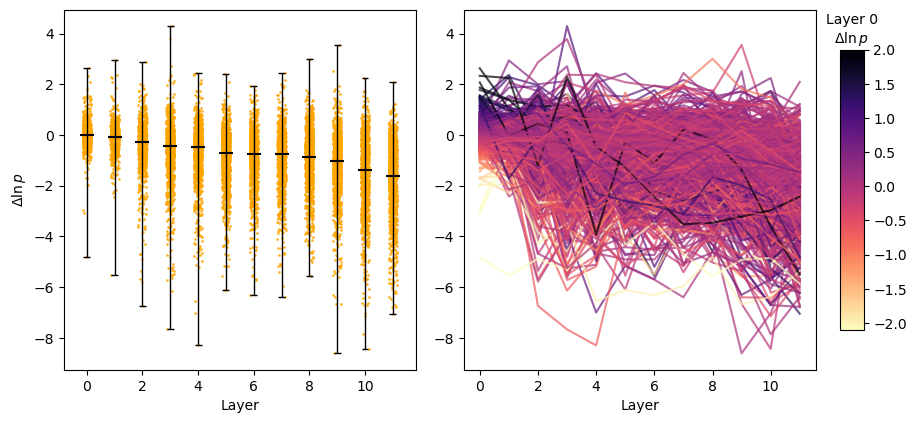

In [240]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_axes([0.00, 0.05, 0.44, 0.9])
ax2 = fig.add_axes([0.50, 0.05, 0.44, 0.9])
cax = fig.add_axes([0.97, 0.15, 0.03, 0.7])


parts = ax1.violinplot([df['delta_ln_prob'][df['layer'] == i] for i in range(12)], positions=np.arange(12))#, showmeans=True)
for partname in ('cbars','cmins','cmaxes'):#'cmeans','cmedians'):
    pc = parts[partname]
    # print(dir(pc))
    pc.set_color('k')
    pc.set_linewidth(1)
    pc.set_alpha(1)
for pc in parts['bodies']:
    pc.set_alpha(0)

    
ax1.scatter(df['layer'] + (np.random.rand(df['layer'].shape[0])-0.5)*0.3, df['delta_ln_prob'], s=1, alpha=0.75, c='orange')
ax1.set_xlabel('Layer')
ax1.set_ylabel(r'$\Delta \ln p$')


for i in range(12):
    ax1.scatter(i, np.percentile(df['delta_ln_prob'][df['layer'] == i], 50), marker='_', c='k', s=100)


# for each data point, get [layer, delta ln p]
x = [i for i in range(12)]
y = [np.array(df['delta_ln_prob'][i::cbt_points]) for i in range(cbt_points)]

norm = matplotlib.colors.Normalize(vmin=-2.1, vmax=2)
sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.magma_r)

for i in range(len(y)):
    ax2.plot(x, y[i], color=sm.to_rgba(y[i][0]), alpha=0.7);
plt.colorbar(sm, cax=cax)
ax2.set_xlabel('Layer')

cax.text(0.5, 1.07, 'Layer 0\n'+r'$\Delta \ln p$', ha='center', va='center', transform=cax.transAxes);

fig.savefig('layer_effect_lambada.png', dpi=300, bbox_inches='tight')
